## <b> Лабораторная работа 3 </b> <br>
## Взаимодействия с сеткой (grid) в KAN <br>
#### Зиберов Александр ИНС-м-о-25-1 <br>

#### <b> Цель работы: </b> Изучение методов расширения и дообучения моделей KAN, а также анализа их способности сохранять ранее полученные знания при непрерывном обучении и разнообразном распределении входных данных.

In [17]:
# Импорт библиотек
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from utils import eval_basis_functions, get_coeff, single_stacked_kan_training

#### **Grid (сетка) в KAN** - это набор контрольных точек, определяющих разбиение области входных данных для построения сплайнов. Она задаёт, где базисные функции будут активироваться и как будут интерполироваться значения функции.

## 1. Повышение потенциала модели в середине обучения

Чтобы повысить мощность KAN без добавления новых нейронов или сплайнов, можно увеличить число параметров за счёт дополнительных контрольных точек, корректируя существующую сетку.

**Процедура увеличения параметров:**
1. **Адаптация контрольных точек**. Цель – разместить больше контрольных точек в существующей сетке. Для этого мы используем сплайн, который сопоставляет стандартные контрольные точки сетки, обычно в диапазоне $[-1, 1]$, с точками в существующей сетке. Для этого вычисляем временные коэффициенты (temp_coef).
2. **Создание большего количества контрольных точек**. Установив сплайн отображения, мы можем прогнозировать и генерировать столько контрольных точек, сколько необходимо, в пределах существующей сетки.

Этот подход становится особенно полезным, когда существующие контрольные точки сетки расположены неравномерно, поскольку сплайн обеспечивает методичный способ интерполяции и формирования новых контрольных точек. Однако для расширения сетки дополнительными контрольными точками можно использовать и другие методы.

Увеличим количество контрольных точек с помощью сплайнов и вычислим новые коэффициенты, чтобы повысить точность аппроксимации без добавления новых сплайнов.

In [18]:
# Степень B-сплайна
k = 3

# Размеры грубой и более плотной сеток
coarse_grid_size = 10
finer_grid_size = 20

# Пример входных значений (pre-активации) и соответствующих выходов (post-активации)
preacts = torch.rand((100, 1))
postacts = torch.sin(preacts) + torch.randn(preacts.shape) * 0.1  # шум добавлен для реалистичности

# Создаём грубую сетку контрольных точек
prev_grid = torch.linspace(-2.5, 2, steps=coarse_grid_size).unsqueeze(dim=0)  # текущая сетка, которую будем расширять

# Учим сплайн для предсказания контрольных точек в существующей сетке
x_pos = prev_grid.transpose(1,0)  # транспонируем для удобства
temp_grid = torch.linspace(-1, 1, steps=coarse_grid_size).unsqueeze(dim=0)
temp_bases = eval_basis_functions(temp_grid.transpose(1, 0), temp_grid, k=1)  # линейная интерполяция в меньшую сетку
temp_coef = get_coeff(temp_bases, x_pos)  # коэффициенты сплайна для предсказания контрольных точек

# Предсказываем больше контрольных точек, используя обученный сплайн
percentiles = torch.linspace(-1, 1, steps=finer_grid_size).unsqueeze(dim=1)
percentiles_basis = eval_basis_functions(percentiles, temp_grid, k=1)
new_grid = torch.einsum('ijk, bij-> bk', temp_coef, percentiles_basis).transpose(1, 0)  # новая плотная сетка

print("Новая сетка контрольных точек (new_grid):")
print(new_grid)

# Вычисляем коэффициенты сплайна для новых контрольных точек
new_bases = eval_basis_functions(preacts, new_grid, k)  # базисные функции для preacts
new_coef = get_coeff(new_bases, postacts)  # коэффициенты для аппроксимации postacts

print("Коэффициенты сплайна для новой сетки (new_coef):")
print(new_coef)

Новая сетка контрольных точек (new_grid):
tensor([[-2.5000, -2.2632, -2.0263, -1.7895, -1.5526, -1.3158, -1.0789, -0.8421,
         -0.6053, -0.3684, -0.1316,  0.1053,  0.3421,  0.5789,  0.8158,  1.0526,
          1.2895,  1.5263,  1.7632,  2.0000]])
Коэффициенты сплайна для новой сетки (new_coef):
tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]])


Перепишем код выше в виде функции для удобства использования далее. 

In [19]:
def update_grid(prev_grid, new_grid_size, k, preacts, postacts):
    """
    Обновление сетки контрольных точек KAN.

    Args:
        prev_grid: сетка контрольных точек (число сплайнов x число точек)
        new_grid_size: новое количество контрольных точек
        k: степень сплайна
        preacts: входные значения (pre-активации)
        postacts: текущие выходы (post-активации)

    Returns:
        new_coef: новые коэффициенты сплайна для сохранения поведения модели
        new_grid: обновлённая сетка с новым количеством контрольных точек
    """
    coarse_grid_size = prev_grid.shape[-1]  # текущее количество точек
    finer_grid_size = new_grid_size          # новое количество точек
    
    # Учим сплайн для предсказания существующих контрольных точек
    x_pos = prev_grid.transpose(1,0)
    temp_grid = torch.linspace(-1, 1, steps=coarse_grid_size).unsqueeze(dim=0)
    temp_bases = eval_basis_functions(temp_grid.transpose(1, 0), temp_grid, k=1)  # линейная интерполяция
    temp_coef = get_coeff(temp_bases, x_pos)  # коэффициенты сплайна для предсказания контрольных точек
    
    # Предсказываем новые контрольные точки
    percentiles = torch.linspace(-1, 1, steps=finer_grid_size).unsqueeze(1)
    percentiles_basis = eval_basis_functions(percentiles, temp_grid, k=1)
    new_grid = torch.einsum('ijk, bij-> bk', temp_coef, percentiles_basis).transpose(1, 0)
    
    # Вычисляем коэффициенты сплайна для новой сетки, чтобы сохранить аппроксимацию
    new_bases = eval_basis_functions(preacts, new_grid, k)
    new_coef = get_coeff(new_bases, postacts)

    return new_coef, new_grid


Теперь обучим KAN на произвольной функции, создадим обучающую и тестовую выборки, а затем последовательно будем увеличивать количество контрольных точек с помощью функции update_grid. После каждого увеличения сетки модель будет дообучаться, чтобы показать, как расширение числа параметров улучшает аппроксимацию функции без переобучения с нуля.

In [20]:
# Задаём функцию для аппроксимации
fn, fn_label = (lambda x: torch.exp(torch.sin(torch.pi * x) + x**2) + (1 / (1 + x**2)),
                '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')

# Генерируем точки для оценки функции
x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)  # добавляем шум для реалистичности

# Разделение на обучающую и тестовую выборки
n_training = int(x_eval.shape[0] * 0.8)
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]

# Параметры модели
lr = 0.1         # скорость обучения
k = 2            # степень сплайна
n_layers = 1     # число слоёв KAN
grid_sizes = [3] # начальное число контрольных точек
grid_range = [-1, 1]

loss_batches = []

# Первичное обучение модели KAN на небольшой сетке
params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(
    x_training, y_training, x_test, y_test,
    lr=lr, k=k, n_layers=n_layers,
    grid_sizes=grid_sizes, verbose=False,
    grid_range=[], use_scales=False
)
loss_batches.append(losses_kan)

# Последовательно увеличиваем количество контрольных точек
for new_grid_size in [5, 8, 10, 12]:    
    prev_grid = params_kan['grids'][0]
    prev_coef = params_kan['coeffs'][0]
    postacts = all_xs[-1][0]  # выход последнего слоя модели
    
    # Расширяем сетку и получаем новые коэффициенты
    new_coef, new_grid = update_grid(prev_grid, new_grid_size, k, x_training, postacts)
    new_coef = new_coef.requires_grad_(True)
    
    # Обновляем параметры модели
    params_kan['grids'] = [new_grid]
    params_kan['coeffs'] = [new_coef]

    print(f"Увеличение числа параметров до {new_grid_size}: Prev grid: {prev_grid.shape} New grid: {new_grid.shape} Prev. Coef: {prev_coef.shape} New Coef: {new_coef.shape}")

    # Дообучение модели на новой сетке
    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(
        x_training, y_training, x_test, y_test,
        model_params=params_kan, lr=lr,
        k=k, n_layers=n_layers,
        grid_sizes=grid_sizes, verbose=False,
        grid_range=[], use_scales=False
    )

    loss_batches.append(losses_kan)

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\User\AppData\Local\Temp\ipykernel_25020\3814979657.py:3: SyntaxWarning: invalid escape sequence '\p'
  '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')


Stopping: No further improvements...
Увеличение числа параметров до 5: Prev grid: torch.Size([1, 3]) New grid: torch.Size([1, 5]) Prev. Coef: torch.Size([1, 4, 1]) New Coef: torch.Size([1, 6, 1])
Stopping: No further improvements...
Увеличение числа параметров до 8: Prev grid: torch.Size([1, 5]) New grid: torch.Size([1, 8]) Prev. Coef: torch.Size([1, 6, 1]) New Coef: torch.Size([1, 9, 1])
Stopping: Iteration limit reached...
Увеличение числа параметров до 10: Prev grid: torch.Size([1, 8]) New grid: torch.Size([1, 10]) Prev. Coef: torch.Size([1, 9, 1]) New Coef: torch.Size([1, 11, 1])
Stopping: Iteration limit reached...
Увеличение числа параметров до 12: Prev grid: torch.Size([1, 10]) New grid: torch.Size([1, 12]) Prev. Coef: torch.Size([1, 11, 1]) New Coef: torch.Size([1, 13, 1])
Stopping: Iteration limit reached...


Построим график изменения функции потерь на валидационной выборке:

Text(0.5, 1.0, 'Функция потерь на валидации:\n$f(x) = e^{sin(\\pi x) + x^2} + \\frac{1}{1+x^2}$')

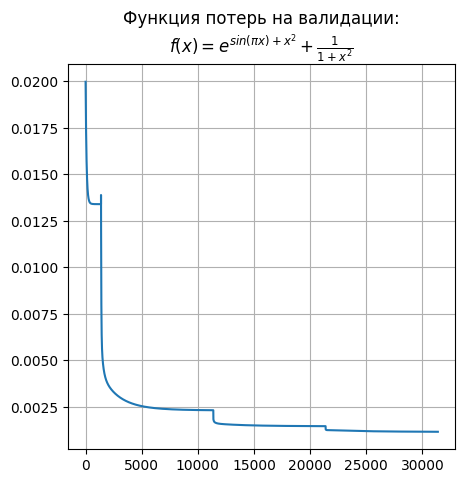

In [21]:
# Создаём фигуру для графика
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), dpi=100)

ax = axs 

# Строим график потерь (loss) на валидационной выборке, фильтруем слишком большие значения
ax.plot([x for losses in loss_batches for x in losses['val'] if x < 0.02])

# Добавляем сетку и заголовок
ax.grid()
ax.set_title(f"Функция потерь на валидации:\n{fn_label}")

График показывает уменьшение ошибки при дообучении KAN с увеличением числа контрольных точек. Можем отметить, что с каждым расширением возможностей модели мы наблюдаем увеличение мощности KAN.

## 2. Постоянное обучение

При непрерывном обучении входные данные могут меняться. В обычных нейросетях это часто вызывает «катастрофическое забывание», когда сеть теряет знания о ранее изученных задачах. KAN решают эту проблему благодаря использованию B-сплайнов в качестве функций активации. Как было выяснено в рамках первой работы, B-сплайны локальны, изменения в одной части кривой не влияют на остальные, что позволяет модели адаптироваться к новым данным, сохраняя старое поведение.

Создадим функцию model_predict, которая будет выполнять прогноз модели KAN для заданных входных данных.

In [22]:
def model_predict(params_kan, x_eval, k):
    """
    Функция для предсказания значений с помощью KAN.
    
    Args:
        params_kan: словарь параметров KAN (сетку, коэффициенты, масштабирование)
        x_eval: входные значения для предсказания
        k: степень сплайна
    
    Returns:
        y_pred: предсказанные значения KAN
    """
    grids = params_kan['grids']           # сетки контрольных точек
    coeffs = params_kan['coeffs']         # коэффициенты сплайнов
    scale_bases = params_kan['scale_bases']   # масштаб базовых функций (если используются)
    scale_splines = params_kan['scale_splines'] # масштаб сплайнов
    base_fns = params_kan['base_fns']     # базовые функции (если есть)
    
    # Проходим по всем слоям KAN
    for idx in range(len(grids)):
        grid, coeff = grids[idx], coeffs[idx]
        
        with torch.no_grad():  # без вычисления градиентов для предсказания
            # Применяем B-сплайны
            x = torch.einsum('ijk, bij -> bk', coeff, eval_basis_functions(x_eval, grid, k))
            
            # Если есть базовые функции и масштабирование
            if len(base_fns) > 0:
                base_fn, scale_sp, scale_base = base_fns[idx], scale_splines[idx], scale_bases[idx]
                x = scale_base * base_fn(x_eval) + scale_sp * x
                
        y_pred = x_eval = x  # сохраняем предсказанное значение и обновляем x_eval для следующего слоя
    
    return y_pred


Создаём последовательный набор данных с несколькими фазами, каждая из которых представляет разные функции (синусоиды с разной частотой). Цель - обучить KAN поочередно на каждой фазе, имитируя сценарий непрерывного обучения, где данные приходят постепенно, а не сразу.

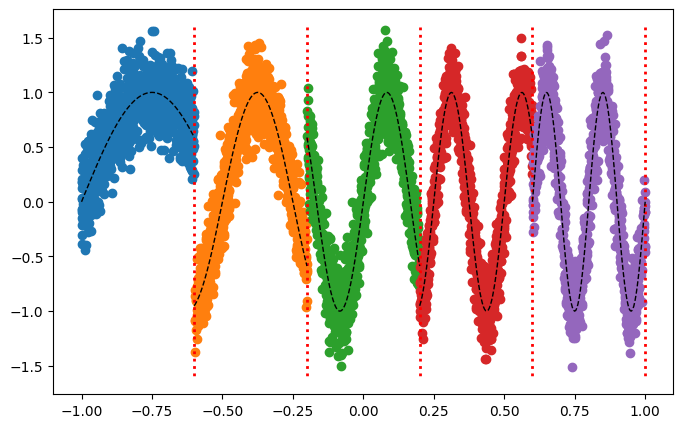

In [23]:
# Фиксируем генератор случайных чисел для воспроизводимости
torch.random.manual_seed(42)

# Создаём фигуру для визуализации данных
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

# Параметры генерации данных
n_samples_per_phase = 1000  # число наблюдений на фазу
noise_level = 0.2            # уровень шума
n_phases = 5                 # количество фаз (разных функций)

# Генерация фаз поочередно
for i in range(n_phases):
    start = -1 + i * 2 / n_phases
    end = start + 2 / n_phases
    x = torch.rand(n_samples_per_phase) * (end - start) + start  # равномерные точки в диапазоне фазы
    
    # Основная функция синус
    y = torch.sin(2 * x * torch.pi * (i + 1)) 
    y_noisy = y + noise_level * torch.randn(y.shape)  # добавляем шум
    
    # Визуализация точек с шумом
    ax.scatter(x, y_noisy)
    
    # Вертикальная линия, отделяющая фазу
    ax.vlines(end, 1.6, -1.6, color='red', linestyle=':', linewidth=2)
    
    # Визуализация чистой функции
    x_ = torch.linspace(start, end, 100)
    y_ = torch.sin(2 * x_ * torch.pi * (i + 1))
    ax.plot(x_, y_, color='black', linewidth=1, linestyle='--')

Создаём последовательный набор данных для трёх задач с разными функциями (синусоиды с разной частотой) в отдельных диапазонах входных значений. Модель KAN обучается поочерёдно на каждой задаче, демонстрируя способность к непрерывному обучению без катастрофического забывания. Графики показывают аппроксимацию KAN по сравнению с истинными функциями и шумными наблюдениями.

Stopping: No further improvements...
Фаза: 0	Потери (Loss):  0.0264
Stopping: No further improvements...
Фаза: 1	Потери (Loss):  0.0495
Stopping: No further improvements...
Фаза: 2	Потери (Loss):  0.0508


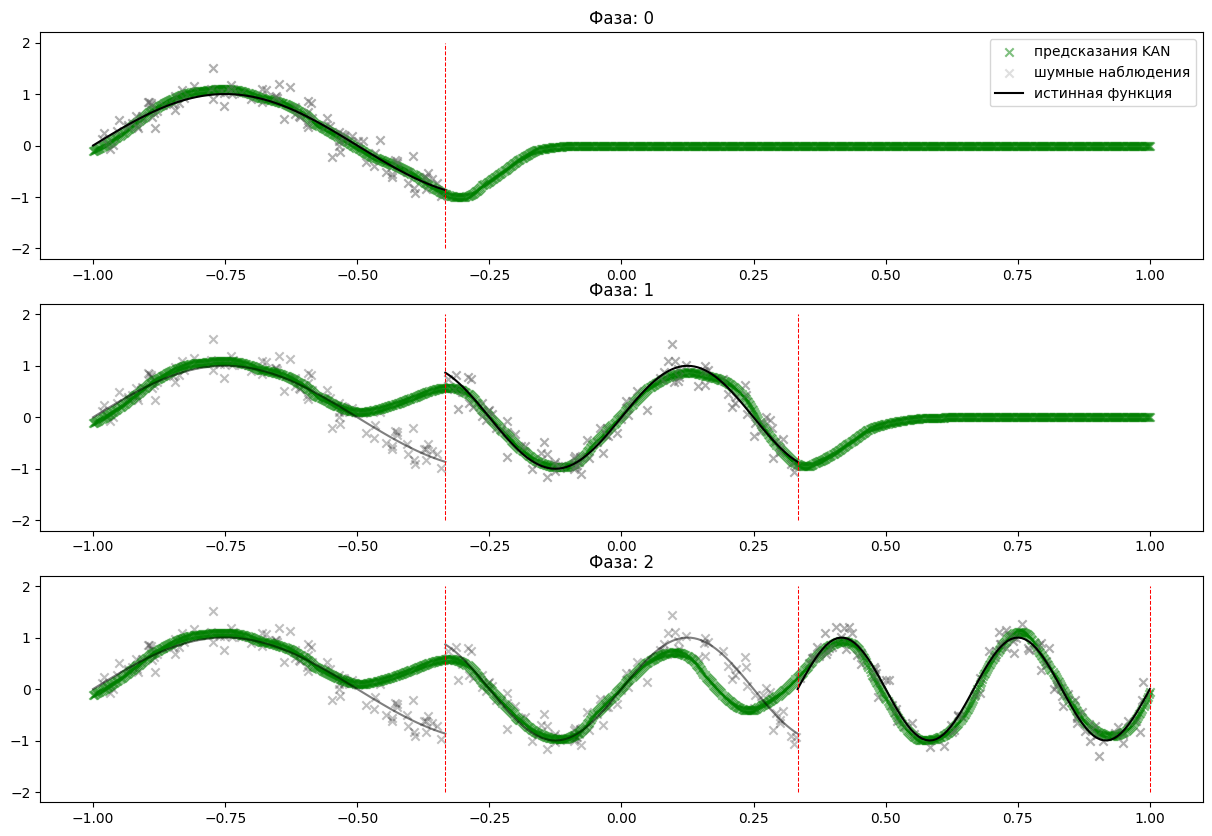

In [24]:
# Параметры генерации данных
n_samples_per_phase = 100  # число наблюдений на фазу
noise_level = 0.2           # уровень шума
n_phases = 3                # количество фаз/задач

# Создаём фигуру для графиков фаз
fig, axs = plt.subplots(nrows=n_phases, ncols=1, figsize=(15, 10), dpi=100)

# Параметры обучения KAN
losses = []
grid_sizes = [20]
grid_range = [-1, 1]
lr = 0.5
k = 3
n_layers = 1

params_kan = None  # начальные параметры модели
x_temps, y_temps, ends, y_noisys = [], [], [], []

for i in range(n_phases):
    # Определяем диапазон текущей фазы
    start = -1 + i * 2 / n_phases
    end = start + 2 / n_phases
    
    # Функция для текущей фазы
    fn = lambda x, i=i: torch.sin(2 * x * torch.pi * (i + 1))
    
    # Генерация точек и добавление шума
    x = torch.rand(n_samples_per_phase) * (end - start) + start
    y = fn(x)
    y_noisy = y + noise_level * torch.randn(y.shape)

    # Подготовка обучающей и тестовой выборки
    x_eval = x.unsqueeze(dim=1)
    y_target = y_noisy.unsqueeze(dim=1)
    n_training = int(x_eval.shape[0] * 0.8)
    training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
    test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
    x_training = x_eval[training_idxs]
    x_test = x_eval[test_idxs]
    y_training = y_target[training_idxs]
    y_test = y_target[test_idxs]

    # Дообучение KAN на текущей фазе
    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(
        x_training, y_training, x_test, y_test,
        lr=lr, model_params=params_kan,
        k=k, n_layers=n_layers,
        grid_sizes=grid_sizes, verbose=False,
        grid_range=[], use_scales=False
    )

    losses.append(losses_kan)
    print(f"Фаза: {i}\tПотери (Loss): {np.mean(losses_kan['val'][-50:]): 0.4f}")

    # Визуализация: точки с шумом и предсказания KAN
    ax = axs[i]
    ax.scatter(x, y_noisy, color='black', marker='x', alpha=0.25)
    for temp_x, temp_y in y_noisys:
        ax.scatter(temp_x, temp_y, color='black', alpha=0.25, marker='x')
    y_noisys.append((x, y_noisy))

    # Предсказания модели на всей области
    x_in = torch.linspace(-1, 1, 1000).unsqueeze(dim=1)
    y_pred = model_predict(params_kan, x_in, k)
    ax.scatter(x_in[:, 0], y_pred, color='green', alpha=0.5, marker='x', label="предсказания KAN")
    ax.scatter(x, y_noisy, color='grey', marker='x', alpha=0.25, label="шумные наблюдения")

    # Истинная функция для текущей фазы
    x_temp = torch.linspace(0, 1, 100) * (end - start) + start
    y_temp = fn(x_temp)
    ax.plot(x_temp, y_temp, linestyle='-',  color='black', label="истинная функция")
    
    # Рисуем функции предыдущих фаз
    for x_prev, y_prev in zip(x_temps, y_temps):
        ax.plot(x_prev, y_prev, linestyle='-', alpha=0.5, color='black')

    # Вертикальные линии для границ фаз
    ends.append(end)
    for x_end in ends:
        ax.vlines(x_end, -2, 2, linestyle='--', color='red', linewidth=0.75)

    ax.set_title(f"Фаза: {i}")
    if i == 0:
        ax.legend()

    # Сохраняем точки текущей фазы для последующего отображения
    x_temps.append(x_temp)
    y_temps.append(y_temp)

Зеленые точки обозначают предсказания изученного KAN. Как наблюдалось на последующих этапах набора данных, функция, полученная из предыдущих входных областей, сохраняется. Такая последовательность позволяет непрерывно учиться без катастрофического забывания.

## Вывод

В ходе работы изучены методы расширения и дообучения KAN. Показано, что модель сохраняет ранее изученные знания при непрерывном обучении и успешно адаптируется к новым входным данным благодаря локальным B-сплайнам.